In [49]:
import numpy as np
from scipy.special import hyp1f1
from sympy import hyper
from scipy import integrate
from scipy.special import gamma
import matplotlib.pyplot as plt
import time as tm
from math import factorial

from __future__ import division

%matplotlib inline

# Defino funcion de Bessel

In [2]:
def Bessel(k,l,r):
    rho = k*float(r)
    
    if rho == 0.0:
        jl = 0
        if l == 0:
            jl = 1
        return jl
    
    j0 = np.sin(rho) / rho
    j1 = np.sin(rho) / rho**2 - np.cos(rho) / rho
    
    if l == 0:
        return j0
    
    if l == 1:
        return j1
    
    for j in range(1,l):
        jl = (2*l-1)/rho * j1 - j0
        j1 = jl
        j0 = j1
        
    return jl

# Defino funcion de Neumann

In [3]:
def Neumann(k,l,r):
    rho = k*r
    n0 = -np.cos(rho) / rho
    n1 = -np.cos(rho) / rho**2 - np.sin(rho) / rho
    
    if l == 0:
        return n0
    
    if l == 1:
        return n1
    
    for j in range(1,l):
        nl = (2*l-1)/rho*n1 - n0
        n1 = nl
        n0 = n1
        
    return nl

# Defino las funciones de onda continuas

In [2]:
def Rkl(k,l,z,r):
    a = z/k
    rnorm = np.sqrt(2/np.pi)*np.exp(a*np.pi/2)*np.abs(gamma(1+l-1j*a))/factorial(2*l+1)
    hyp = hyper((-1j*a+l+1,), (2*l+2,), -2*1j*k*r).evalf()
    rfunc = k*(2*k*r)**l * np.exp(1j*k*r) * hyp #hyp1f1(-1j*a+l+1, 2*l+2, -2*1j*k*r)
    R = rnorm * rfunc
    return R

In [3]:
def Rkl_io(k,l,z,io,r):
    a = z/k
    return Rkl(k,l,z,r)*(1j)**(-io*l)*np.exp(io*1j*np.angle(gamma(1+l-1j*a)))

In [4]:
def Rkl_conj(k,l,z,r):
    a = z/k
    rnorm = np.sqrt(2/np.pi)*np.exp(a*np.pi/2)*np.abs(gamma(1+l-1j*a))/factorial(2*l+1)
    hyp = hyper((1j*a+l+1,), (2*l+2,), 2*1j*k*r).evalf()
    rfunc = k*(2*k*r)**l * np.exp(-1j*k*r) * hyp #hyp1f1(-1j*a+l+1, 2*l+2, -2*1j*k*r)
    R = rnorm * rfunc
    return R

In [5]:
def Rkl_io_conj(k,l,z,io,r):
    a = z/k
    return Rkl_conj(k,l,z,r)*(-1j)**(-io*l)*np.exp(io*(-1j)*np.angle(gamma(1+l+1j*a)))

In [18]:
print integrate.quad(lambda r: (r**2*np.abs(Rkl_io(0.5,0,4,1,r)*Rkl_io(1000,0,4,1,r))),0,np.inf)
#integrate.dblquad(lambda r,k: (r**2*np.abs(Rkl_io(10,0,4,1,r)*Rkl_io(k,0,4,1,r))),0,np.inf,lambda x: 0,lambda x: 20)
#ks = np.arange(0.1,5,0.1)

(37926.27310405104, 64755.91700341288)


# Simbolico

In [68]:
import sympy as sp
from sympy import oo
from sympy import gamma
from sympy import Rational
from __future__ import division

In [135]:
sp.init_printing()
r = sp.Symbol('r', positive=True, real=True)
k = sp.Symbol('k', positive=True, real=True)
l = sp.Symbol('l', positive=True, integer=True)
n = sp.Symbol('n', positive=True, integer=True)
z = sp.Symbol('z', positive=True, integer=True)

In [149]:
def Rkl(k,l,z,r):
    #a = z/k
    rnorm = k*sp.sqrt(2/sp.pi)*sp.exp(z/k*sp.pi/2)*sp.Abs(gamma(1+l-sp.I*z/k))/sp.factorial(2*l+1)
    #rnorm = 1
    hyp = hyper((-sp.I*z/k+l+1,), (2*l+2,), -2*sp.I*k*r)
    rfunc = (sp.I)**(l)*(2*k*r)**l * sp.exp(sp.I*k*r) * hyp #hyp1f1(-1j*a+l+1, 2*l+2, -2*1j*k*r)
    R = rnorm * rfunc
    return R

In [150]:
def Rkl_io(k,l,z,io,r):
    #a = z/k
    return Rkl(k,l,z,r)*(sp.I)**(-io*l)*sp.exp(io*1j*sp.arg(gamma(1+l-sp.I*z/k)))

# Chequeo la ec de Schrodinger

In [151]:
#(-1/2*sp.diff((r*Rkl_io(k,l,z,1,r)),r,2)+(-z/r+l*(l+1)/(2*r**2)-k**2/2)*(r*Rkl_io(k,l,z,1,r))).evalf(subs={k:1,l:0,z:4,r:10})0
-1/2*sp.diff((r*Rkl(k,l,z,r)),r,2)+(-z/r+l*(l+1)/(2*r**2)-k**2/2)*(r*Rkl(k,l,z,r))

                                                                              
                                                                              
                                                                              
              _______________________________          ⎛   2                ⎞ 
    l        ╱  ⎛        ⅈ⋅z⎞  ⎛        ⅈ⋅z⎞         l ⎜  k    l⋅(l + 1)   z⎟ 
√2⋅ⅈ ⋅k⋅r⋅  ╱  Γ⎜l + 1 - ───⎟⋅Γ⎜l + 1 + ───⎟ ⋅(2⋅k⋅r) ⋅⎜- ── + ───────── - ─⎟⋅
          ╲╱    ⎝         k ⎠  ⎝         k ⎠           ⎜  2          2     r⎟ 
                                                       ⎝          2⋅r       ⎠ 
──────────────────────────────────────────────────────────────────────────────
                                                     √π⋅(2⋅l + 1)!            

                                                                              
                                                                              
        π⋅z                                        

In [126]:
LHS = -0.5*sp.diff((r*Rkl_io(k,l,z,1,r)),r,2)+(-z/r+l*(l+1)/(2*r**2))*(r*Rkl_io(k,l,z,1,r))
RHS = k**2/2*(r*Rkl_io(k,l,z,1,r))

In [127]:
k0 = 10
l0 = 3
z0 = 4
nsize = 200
rs = np.linspace(0.01,40,nsize)

In [129]:
LHS_eval_real = np.zeros(nsize)
RHS_eval_real = np.zeros(nsize)
LHS_eval_imag = np.zeros(nsize)
RHS_eval_imag = np.zeros(nsize)

for i,r0 in enumerate(rs):
    LHS_eval = LHS.evalf(subs={k:k0,l:l0,z:z0,r:r0})
    RHS_eval = RHS.evalf(subs={k:k0,l:l0,z:z0,r:r0})
    
    LHS_eval_real[i] = sp.re(LHS.evalf(subs={k:k0,l:l0,z:z0,r:r0}))
    RHS_eval_real[i] = sp.re(RHS.evalf(subs={k:k0,l:l0,z:z0,r:r0}))
    LHS_eval_imag[i] = sp.im(LHS.evalf(subs={k:k0,l:l0,z:z0,r:r0}))
    RHS_eval_imag[i] = sp.re(RHS.evalf(subs={k:k0,l:l0,z:z0,r:r0}))
    if i%(nsize/10) == 0: print i


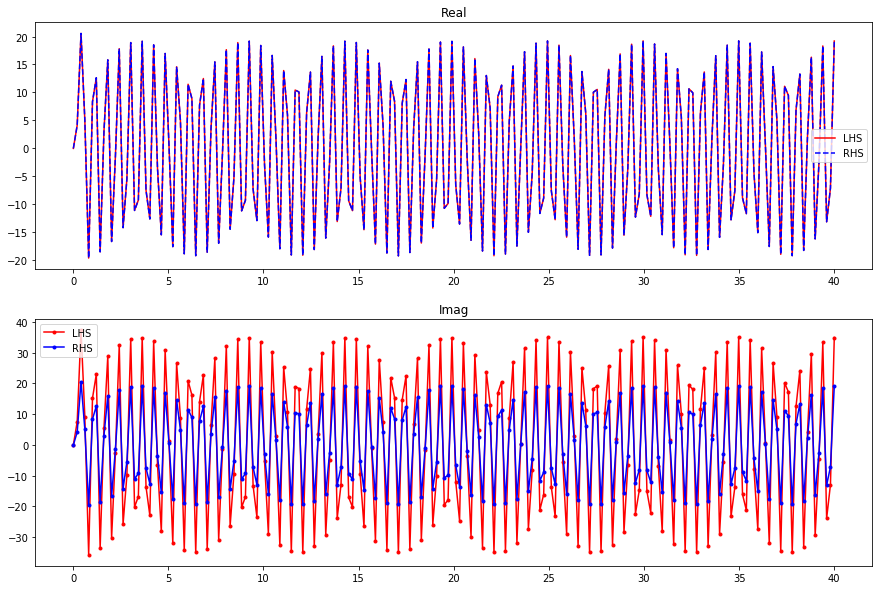

In [134]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
ax1.plot(rs, LHS_eval_real, 'r-', label='LHS')
ax1.plot(rs, RHS_eval_real, 'b--', label='RHS')
ax1.set_title("Real")
ax1.legend(loc='best')

ax2.plot(rs, LHS_eval_imag, 'r.-', label='LHS')
ax2.plot(rs, RHS_eval_imag, 'b.-', label='RHS')
ax2.set_title("Imag")
ax2.legend(loc='best')



# Chequeo 3 k's cercanos

In [11]:
nsize = 500
xmax = 5
xmin = 0.
x = np.linspace(xmin,xmax,nsize)
psi_1 = np.zeros(nsize, dtype=complex)
psi_2 = np.zeros(nsize, dtype=complex)
psi_3 = np.zeros(nsize, dtype=complex)
klist = [0.5,0.6,0.7]

In [12]:
for i in range(nsize):
    psi_1[i] = Rkl(klist[0],0,1,x[i]).evalf()
    psi_2[i] = Rkl(klist[1],0,1,x[i]).evalf()
    psi_3[i] = Rkl(klist[2],0,1,x[i]).evalf()

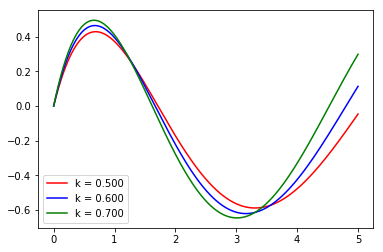

In [13]:
plt.plot(x,x*psi_1.real,'r',label='k = {:.3f}'.format(klist[0]))
plt.plot(x,x*psi_2.real,'b',label='k = {:.3f}'.format(klist[1]))
plt.plot(x,x*psi_3.real,'g',label='k = {:.3f}'.format(klist[2]))
plt.legend(loc='best')
plt.show()

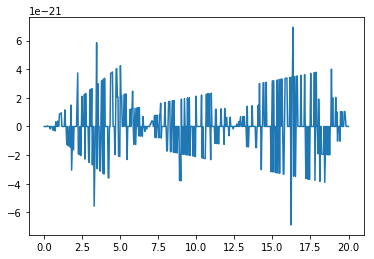

In [26]:
plt.plot(x,x*psi_1.imag)
plt.show()

# Chequeo para Z = 0 si da Bessel

In [19]:
xmax = 20
xmin = 0
nsize = 500
x = np.linspace(xmin,xmax,nsize)
psi = np.zeros(nsize,dtype = complex)
jbes = np.zeros(nsize)

In [20]:
k = 2.05627032187
lq = 1
"""rinf = 10*(lq+1) / k  # kr = 10*l
psiinf = Rkl(k,lq,0,rinf).evalf()
fjlinf = Bessel(k,lq,rinf)
fnorm = fjlinf/psiinf
print fnorm"""
for i in range(nsize):
    psi[i] = Rkl(k,1,0,x[i])
    jbes[i] = Bessel(k,1,x[i])

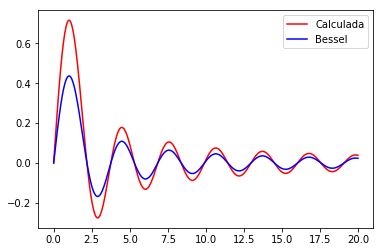

In [21]:
plt.plot(x,psi.real,'r',label='Calculada')
plt.plot(x,jbes,'b',label='Bessel')
plt.legend(loc='best')

# Kato

In [62]:
sp.N(sp.diff(Rkl_io(1,0,90,1,r),r,1)/Rkl_io(1,0,90,1,r),subs={r:0})

NameError: global name 'hyper' is not defined